## Итоговое задание по проекту "0-project_4-банковский_скоринг"
https://www.kaggle.com/alexeytyurnin

Alexey Tyurnin, skillfactory-DST-14, gterrans@gmail.com

Дата выполнения: 12.10.2020

### Импорт библиотек

In [148]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime as dtm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

### Загрузка данных и проведение анализа данных

Для анализа объеденим тренировочые и проверочные данные, исключим целевую переменную

In [149]:
DATA_DIR = 'kaggle\\input\\sf-dst-scoring'
df_train = pd.read_csv(DATA_DIR+'\\train.csv')

df_train = df_train.drop(['default'], inplace=False, axis=1)
df_test = pd.read_csv(DATA_DIR+'\\test.csv')

# Объединяем трейн и тест в один датасет
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.drop(['client_id'], inplace=True, axis=1)  # нет информации
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   app_date          110148 non-null  object 
 1   education         109670 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

В объеденённой выборке 110148 клиентов. Всего 17 переменных, из них 1 - дата, 5 бинарных, 6 категориальных и 5 числовых. В переменной education 272 пропусков.

Восстановим данные по образованию

In [150]:
# пропущенные записи в education
def change_edu(s):
    if type(s) == str:
        return s
    else:
        return 'NO'    # отсутствие записи - новая категория

data['education'] = data['education'].apply(change_edu)
data['education'].value_counts()
# всего 6 видов категорий образования вместе с отсутствующей записью

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NO       478
ACD      291
Name: education, dtype: int64

Перобразуем дату (признак 'app_date')

In [151]:
# преобразование данных
# app_date
from datetime import datetime as dtm

lendate = data['app_date'].str.len()
lendate.value_counts()
# везде длина 9 символов

9    110148
Name: app_date, dtype: int64

In [152]:
def convert_date(data):
    strdate = data['app_date']
    newdate = np.zeros((strdate.shape[0], 3))

    def parse_date(dtstr):
        newstr_dt = dtstr[0:2]+'-'+dtstr[2:5]+'-'+dtstr[5:]
        return dtm.strptime(newstr_dt, '%d-%b-%Y')

    for irow, row in enumerate(strdate):
        dtrow = parse_date(row)
        newdate[irow][0] = dtrow.year
        newdate[irow][1] = dtrow.month
        newdate[irow][2] = dtrow.day

    df_date = pd.DataFrame(newdate[:,1:], columns=[ 'month', 'day'])
    # год не нужен он один!! 2014  'year',
    # месяц - 4 штуки - в категорию

    data.drop(['app_date'], inplace=True, axis=1)
    data = pd.concat([data, df_date], axis=1)
    return data

data = convert_date(data)

В датасет добавлены признаки месяц и день вместо признака 'app_date', будем считать их категориями.
Далее смотрим на 'sna'

In [153]:
# sna - 4 position 1-4 int
data['sna'].value_counts()


1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

4 возможных значения признака, считаем категорией

In [154]:
# first_time - 4 position 1-4 int
data['first_time'].value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

То же 4 значения - категория.

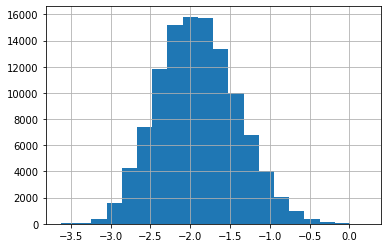

In [155]:
# score_bki - float
score_bki = data['score_bki']#.hist(bins=20)
score_bki.hist(bins=20) # посмотреть выбросы

score_bki - похожее на нормально распрделеённую числовую величину.

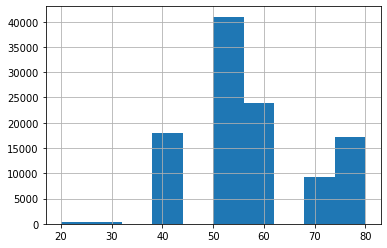

In [156]:
# region_rating ( 7 значений наверное категория!!!)
region_rating = data['region_rating']
vc_rr = region_rating.value_counts()
region_rating.hist()

region_rating - 7 возможных значений, считаем категорией

Распределим признаки по их принадлежности к видам.

In [157]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'home_address', 'work_address']

# дополнительные признаки
add_cat = ['sna', 'first_time', 'region_rating', 'month', 'day']
add_num = ['score_bki'] # не нужен логарифм

Анализ числовых переменных, для num_cols - возьмём логарифм для уменьшения диапазона значений.

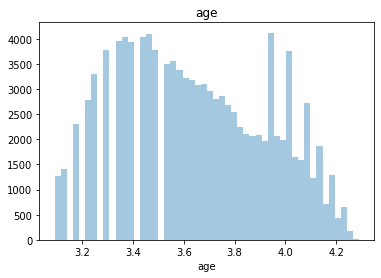

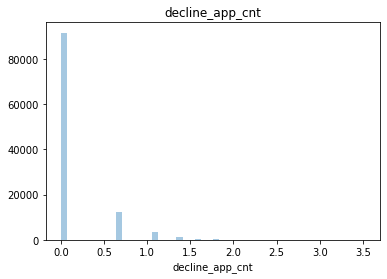

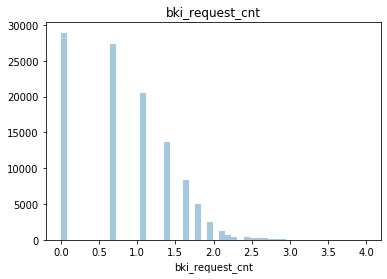

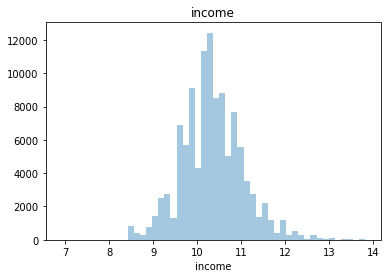

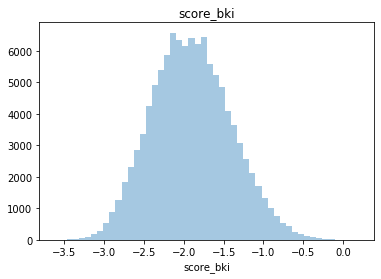

In [158]:
for i in num_cols:
    data[i] = np.log(data[i]+1) 

num_cols = num_cols + add_num
for i in num_cols:    
    sns.distplot(data[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Компактно распределённые числовые признаки, некоторые похожи на нормальные распределения. Анализ на выбросы проводить не буду, если они и есть, то в незначительном количестве.

## Анализ значимости признаков на целевую переменную

Нужна целевая переменная 'default', поэтому загружаем данные train и по ним проверяем зависимости.

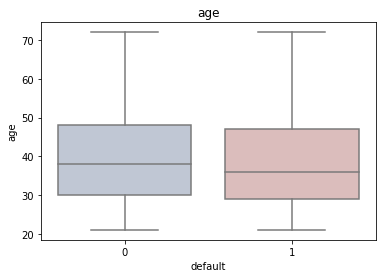

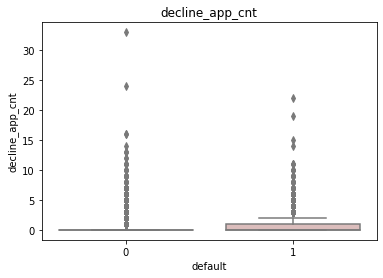

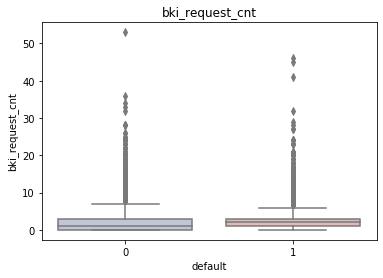

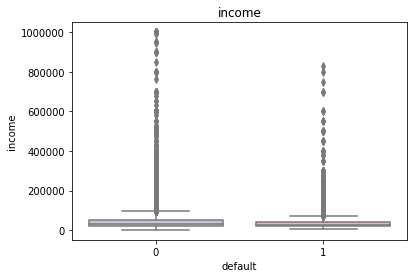

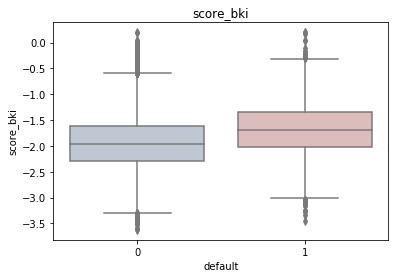

In [159]:
data = pd.read_csv(DATA_DIR+'\\train.csv')

# Сначала числовые переменные

for i in num_cols:
    sns.boxplot(x='default', y=i, data=data, palette="vlag")
    plt.title(i)
    plt.show()   

Видна разница распределений у 'score_bki'

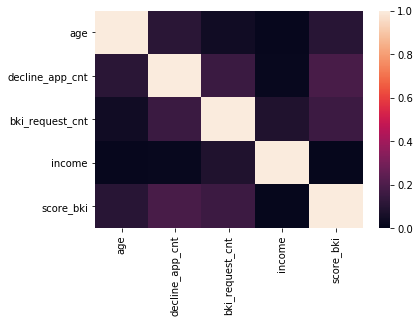

In [160]:

sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Взаимных корреляций у числовых признаков нет, на вид модуль коэффициента корреляции < 0.3 везде.

Проведеём однофакторный дисперсионный анализ.

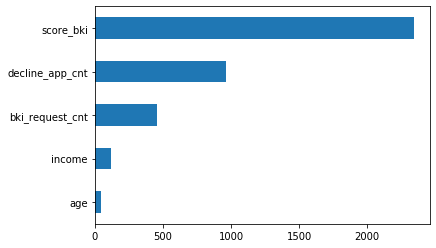

In [161]:
# однофакторный дисперсионный анализ
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


Наибольшая зависимость у признака 'score_bki', наименьшая у 'age'

Исследуем бинарные и категориальные признаки и их влияние на целевую переменную


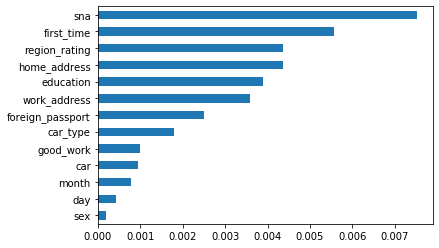

In [162]:
# восстановим месяц и число
data = convert_date(data)

# поправим образование
data['education'] = data['education'].apply(change_edu)

bc_cols = bin_cols + cat_cols + add_cat
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bc_cols:
    data[column] = label_encoder.fit_transform(data[column])

imp_cat = Series(mutual_info_classif(data[bc_cols], data['default'],
                                     discrete_features =True), index = bc_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# конец анализа данных

Наибольшее влияние оказывает 'sna', наименьшее 'sex'

## Функции преобразования данных для машинного обучения
По результатам исследования выбрана обработка, которая будет заключена в этих функциях

In [163]:
# функция обработки данных (по результатам исследования)
def change_edu(s):
    if type(s) == str:
        return s
    else:
        return 'NO'    # отсутствие записи - новая категория

def parse_month(dtstr):
    newstr_dt = dtstr[0:2]+'-'+dtstr[2:5]+'-'+dtstr[5:]
    return dtm.strptime(newstr_dt, '%d-%b-%Y').month

def preprocessing_data(data):
    """
    Parameters
    ----------
    data : Датафрейм для преобразования

    Returns
    -------
    numpy.array с переведёнными в числовую форму признаками,
    +нормализация, dummy-кодирование
    """

    # убрать пропуски в образовании
    data['education'] = data['education'].apply(change_edu)

    # из даты оставляем только месяц
    data['app_date'] = data['app_date'].apply(parse_month)

    # для числовых
    num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income'] # лог.
    add_num = ['score_bki'] # не нужен логарифм
    for col1 in num_cols:
        data[col1] = np.log(data[col1]+1)

    # бинарные и категориальные
    bin_cols = [ 'sex', 'car', 'car_type', 'good_work', 'foreign_passport'] #
    cat_cols = ['education', 'home_address', 'work_address']
    # добавленные категории
    add_cat = ['sna', 'first_time', 'region_rating', 'app_date']

    # Для бинарных признаков мы будем использовать LabelEncoder
    bc_cols = bin_cols + cat_cols + add_cat
    label_encoder = LabelEncoder()
    for column in bc_cols:
        data[column] = label_encoder.fit_transform(data[column])

    # dummy-кодирование
    cat_cols1 = cat_cols + add_cat
    data_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols1].values)

    # нормализация числовых признаков
    num_cols1 = num_cols + add_num
    data_num = StandardScaler().fit_transform(data[num_cols1].values)
    # data_num = data[num_cols1].values

    # склеивание
    npdata = np.hstack([data_num, data[bin_cols].values, data_cat])

    return npdata

Для обучения подгружаем данные и преобразуем их.

In [164]:
# формируем данные для обучения
DATA_DIR = 'kaggle\\input\\sf-dst-scoring'

df_train = pd.read_csv(DATA_DIR+'\\train.csv')
y = df_train['default'].values
df_train = df_train.drop(['default'], inplace=False, axis=1)
df_test = pd.read_csv(DATA_DIR+'\\test.csv')
client_id_kgtest = df_test['client_id']

df_train.drop(['client_id'], inplace=True, axis=1)
df_test.drop(['client_id'], inplace=True, axis=1)

x = preprocessing_data(df_train)
x_kgtest = preprocessing_data(df_test)
x.shape

(73799, 41)

Функция для обучения логической регрессии

In [165]:
# 
RAND = 42
TST_SIZE = 0.3

def log_regress(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TST_SIZE, random_state=RAND)
    # model = LogisticRegression(max_iter=1000, penalty='l2', C=4.28, solver='newton-cg')
    model = LogisticRegression(max_iter=1000, penalty='l2', C=4.28)
    model.fit(x_train, y_train.ravel())
    probs = model.predict_proba(x_test)
    probs = probs[:,1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    y_pred = model.predict(x_test)
    
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    return model, y_test, y_pred

Начинаем обучение на полном тренировочном датасете

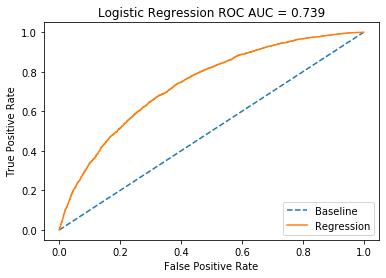

Accuracy: 0.8733
Precision: 0.4309
Recall: 0.0281
F1: 0.0527
[[0.99467975 0.00532025]
 [0.97194245 0.02805755]]


In [166]:
model_full, y_test, y_pred = log_regress(x, y)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

confmat_f = confusion_matrix(y_test, y_pred, normalize='true')
print(confmat_f)

Как видно параметр качества F1 исключительно низкий, также видно из confusion-матрицы, это связано с низким уровнем правильных определений дефолта. Скорее всего это связано с небалансированностью выборки. Поскольку данных помеченных как 'default' = 1 около 12%.
Попробуем сделать сбалансированную выборку.

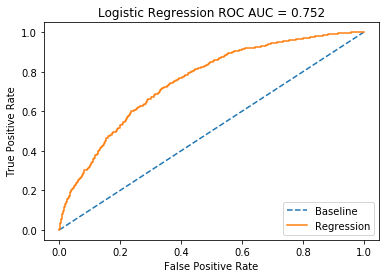

Accuracy: 0.6915
Precision: 0.7071
Recall: 0.7317
F1: 0.7192
[[0.64424951 0.35575049]
 [0.26827243 0.73172757]]


In [167]:
# сбалансированная выборка

sy = Series(y)
vc_sy = sy.value_counts()

xrow = x.shape[0]
xcol = x.shape[1]

n_y1 = vc_sy[1]
n_y0 = vc_sy[0]

ratio_10 = n_y1/xrow # отношение дефолтов ко всему объёму данных

x1 = np.empty((n_y1, xcol))
x0 = np.empty((n_y0, xcol))

# y1 = np.ones((n_y1, 1))
# y0 = np.zeros((n_y0, 1))

ix0 = 0
ix1 = 0
for row in range(xrow):
    if y[row] == 0:
        x0[ix0,:] = x[row,:]
        ix0 += 1
    else:
        x1[ix1,:] = x[row,:]
        ix1 += 1

RAND = 49
TST_SIZE = ratio_10
x0_big, x0_small = train_test_split(x0, test_size=TST_SIZE, random_state=RAND)

sz_small = x0_small.shape[0]
y0 = np.zeros((x0_small.shape[0], 1))
y1 = np.ones((n_y1, 1))

bal_x = np.vstack([x0_small, x1])
bal_y = np.vstack([y0, y1])


model_balance, y_test, y_pred = log_regress(bal_x, bal_y)
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))
bal = confusion_matrix(y_test, y_pred, normalize='true')
print(bal)

Как видно параметр F1 значительно вырос и процент определения дефолтов достиг 73%, правда величина ошибок false positive также выросла и теперь не дадут заслуженный кредит 35% клиентов.

## Подборка гиперпараметров
Расчёт был очень долгий, в коментарии приведён результат.
Как вывод подборка не сильно изменяет показатели качества.

In [168]:
# подбор гиперпараметров
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 20)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

#model = LogisticRegression(max_iter=1000) #  max_iter=1000
#model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring='f1')
# best_model = clf.fit(x_train, y_train)

# View best hyperparameters
#print('Лучшее Penalty:',    best_model.best_estimator_.get_params()['penalty'])
#print('Лучшее C:',          best_model.best_estimator_.get_params()['C'])
#print('Лучший solver:',     best_model.best_estimator_.get_params()['solver'])

# Лучшее Penalty: l2
# Лучшее C: 4.281332398719393
# Лучший solver: newton-cg


## Данные для Kaggle

In [170]:
sample_submission0 = pd.read_csv(DATA_DIR+'/sample_submission.csv')
predict_kgtest = model_balance.predict_proba(x_kgtest)
predict_kgtest = predict_kgtest[:,1]
sample_submission = pd.DataFrame(client_id_kgtest, columns=['client_id'])
sample_submission['default'] = predict_kgtest
sample_submission.to_csv('submission.csv', index=False)
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  36349 non-null  int64  
 1   default    36349 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 568.1 KB


Выводы.
Достигнут ROC_AUC=0.752
Параметр F1=0.7192
В повышении параметра качества основную роль сыграла сбалансированная выборка.
Подбор гиперпараметров ещё не достаточно мной отработан и результат не улучшил.
Работа с выбросами не проводилась, можно было исключить ещё мадозначащие параметры,
но не укладывался в тайминг.
